In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import os


def create_directories():
    if not os.path.exists('../Results'):
        os.makedirs('../Results')
    if not os.path.exists('../Results/Confusion Matrices'):
        os.makedirs('../Results/Confusion Matrices')
    if not os.path.exists('../Results/Final Scores'):
        os.makedirs('../Results/Final Scores')


def hyperparameter_search(X_train, y_train, X_val, y_val, classifier, param_grid):
    print(f"Realizando busca de hiperparâmetros para {type(classifier).__name__}...")
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    model = classifier.set_params(**best_params)
    model.fit(X_train, y_train)

    # Avaliação no conjunto de validação
    predictions_val = model.predict(X_val)
    score_val = classification_report(y_val, predictions_val, output_dict=True)["accuracy"]
    print(f"Busca de hiperparâmetros concluída para {type(classifier).__name__}.")

    return best_params, score_val


def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, classifier_name, classifier, param_grid, file_name, results):
    print(f"Iniciando treinamento e avaliação para {classifier_name}...")
    # Busca de hiperparâmetros e avaliação no conjunto de validação
    best_params, score_val = hyperparameter_search(X_train, y_train, X_val, y_val, classifier, param_grid)
    
    # Treino com hiperparâmetros ajustados
    model = classifier.set_params(**best_params)
    model.fit(X_train, y_train)

    # Avaliação final no conjunto de teste
    predictions_test = model.predict(X_test)
    report = classification_report(y_test, predictions_test, output_dict=True)
    
    # Salvando as métricas
    results.append({
        "Nome do arquivo .csv": file_name,
        "Classifier": classifier_name,
        "Melhores Hiperparâmetros": best_params,
        "Score de Validação": score_val,
        "Acurácia": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"]
    })

    # Plotando e salvando a matriz de confusão
    cm = confusion_matrix(y_test, predictions_test, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    if not os.path.exists(f'../Results/Confusion Matrices/{file_name}'):
        os.makedirs(f'../Results/Confusion Matrices/{file_name}')

    plt.title(f"Matriz de Confusão para {classifier_name} - {file_name}")
    plt.savefig(f"../Results/Confusion Matrices/{file_name}/{file_name}_{classifier_name}.png")
    print(f"Treinamento e avaliação para {classifier_name} concluídos.")


def process_dataset(train_file, test_file, results):
    print(f"Carregando dados de {train_file} e {test_file}...")
    # Carrega os dados
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # Separa features e target
    X_train_full = train_data.iloc[:, :-1]
    y_train_full = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, :-1]
    y_test = test_data.iloc[:, -1]

    # Divide o conjunto de treino em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # Definindo hiperparâmetros para cada classificador
    param_grids = {
        'Logistic Regression': [{
            'C': [0.1, 1, 10],
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2']
        }, {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs'],
            'penalty': ['l2', None]
        }, {
            'C': [0.1, 1, 10],
            'solver': ['saga'],
            'penalty': ['l1', 'l2', None]
        }],
        
        'K-Nearest Neighbors': {
            'n_neighbors': [1, 5, 10],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },

        'Random Forest': {
            'n_estimators': [10, 50, 100],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_split': [2, 4, 6]
        },

        'Decision Tree': {
            'max_depth': [5, 10, 20],
            'criterion': ['gini', 'entropy'],
            'min_samples_leaf': [1, 2, 4]
        },

        'XGB': {
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'subsample': [0.6, 0.8, 1.0]
        },
        
        'LGBM': {
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [50, 100, 200],
            'num_leaves': [31, 62, 124],
            'boosting_type': ['gbdt', 'dart', 'goss']
        }
    }

    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Random Forest', RandomForestClassifier(random_state=42)),
        ('Decision Tree', DecisionTreeClassifier(random_state=42)),
        #('XGB', XGBClassifier(random_state=42)),
        #('LGBM', LGBMClassifier(random_state=42))
    ]


    file_name = os.path.basename(train_file)

    # Treina, ajusta hiperparâmetros, avalia e salva resultados para cada classificador
    for name, classifier in classifiers:
        param_grid = param_grids.get(name, {})
        train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, name, classifier, param_grid, file_name, results)


def main(train_folder, test_folder):
    create_directories()
    results = []
    # Processa cada par de arquivos CSV em treino e teste
    for file in os.listdir(train_folder):
        print('-----------------------------------------------------------------------------------')
        if file.endswith('.csv'):
            train_file = os.path.join(train_folder, file)
            test_file = os.path.join(test_folder, file)
            process_dataset(train_file, test_file, results)
        print('-----------------------------------------------------------------------------------')

    # Cria DataFrame dos resultados e salva em CSV
    results_df = pd.DataFrame(results)
    results_df.sort_values(by="F1-Score", ascending=False, inplace=True)
    print("Salvando resultados finais em CSV...")
    results_df.to_csv("../Results/Final Scores/classification_results.csv", index=False)
    print("Diretórios de resultados criados.")


In [51]:
train_folder = '../datasets/Brain_Cancer_RGB_3classes_axial_256x256_2024/Brain_Cancer_RGB_3classes_axial_256x256_2024_features/Train'
test_folder = '../datasets/Brain_Cancer_RGB_3classes_axial_256x256_2024/Brain_Cancer_RGB_3classes_axial_256x256_2024_features/Test'

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
Carregando dados de ../datasets/Brain_Cancer_RGB_3classes_axial_256x256_2024/Brain_Cancer_RGB_3classes_axial_256x256_2024_features/Train/EfficientNetV2L_output.csv e ../datasets/Brain_Cancer_RGB_3classes_axial_256x256_2024/Brain_Cancer_RGB_3classes_axial_256x256_2024_features/Test/EfficientNetV2L_output.csv...
Iniciando treinamento e avaliação para Logistic Regression...
Realizando busca de hiperparâmetros para LogisticRegression...


/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C a

Busca de hiperparâmetros concluída para LogisticRegression.


/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Treinamento e avaliação para Logistic Regression concluídos.
Iniciando treinamento e avaliação para K-Nearest Neighbors...
Realizando busca de hiperparâmetros para KNeighborsClassifier...
Busca de hiperparâmetros concluída para KNeighborsClassifier.
Treinamento e avaliação para K-Nearest Neighbors concluídos.
Iniciando treinamento e avaliação para Random Forest...
Realizando busca de hiperparâmetros para RandomForestClassifier...
Busca de hiperparâmetros concluída para RandomForestClassifier.
Treinamento e avaliação para Random Forest concluídos.
Iniciando treinamento e avaliação para Decision Tree...
Realizando busca de hiperparâmetros para DecisionTreeClassifier...
Busca de hiperparâmetros concluída para DecisionTreeClassifier.
Treinamento e avaliação para Decision Tree concluídos.
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
-------------------------------------

/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C a

Busca de hiperparâmetros concluída para LogisticRegression.


/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Treinamento e avaliação para Logistic Regression concluídos.
Iniciando treinamento e avaliação para K-Nearest Neighbors...
Realizando busca de hiperparâmetros para KNeighborsClassifier...
Busca de hiperparâmetros concluída para KNeighborsClassifier.
Treinamento e avaliação para K-Nearest Neighbors concluídos.
Iniciando treinamento e avaliação para Random Forest...
Realizando busca de hiperparâmetros para RandomForestClassifier...
Busca de hiperparâmetros concluída para RandomForestClassifier.
Treinamento e avaliação para Random Forest concluídos.
Iniciando treinamento e avaliação para Decision Tree...
Realizando busca de hiperparâmetros para DecisionTreeClassifier...
Busca de hiperparâmetros concluída para DecisionTreeClassifier.
Treinamento e avaliação para Decision Tree concluídos.
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
Carregando dados de ../datasets/Brain

/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C a

Busca de hiperparâmetros concluída para LogisticRegression.


/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Treinamento e avaliação para Logistic Regression concluídos.
Iniciando treinamento e avaliação para K-Nearest Neighbors...
Realizando busca de hiperparâmetros para KNeighborsClassifier...
Busca de hiperparâmetros concluída para KNeighborsClassifier.
Treinamento e avaliação para K-Nearest Neighbors concluídos.
Iniciando treinamento e avaliação para Random Forest...
Realizando busca de hiperparâmetros para RandomForestClassifier...
Busca de hiperparâmetros concluída para RandomForestClassifier.
Treinamento e avaliação para Random Forest concluídos.
Iniciando treinamento e avaliação para Decision Tree...
Realizando busca de hiperparâmetros para DecisionTreeClassifier...
Busca de hiperparâmetros concluída para DecisionTreeClassifier.
Treinamento e avaliação para Decision Tree concluídos.
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
-------------------------------------

/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C a

Busca de hiperparâmetros concluída para LogisticRegression.


/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Treinamento e avaliação para Logistic Regression concluídos.
Iniciando treinamento e avaliação para K-Nearest Neighbors...
Realizando busca de hiperparâmetros para KNeighborsClassifier...
Busca de hiperparâmetros concluída para KNeighborsClassifier.
Treinamento e avaliação para K-Nearest Neighbors concluídos.
Iniciando treinamento e avaliação para Random Forest...
Realizando busca de hiperparâmetros para RandomForestClassifier...
Busca de hiperparâmetros concluída para RandomForestClassifier.
Treinamento e avaliação para Random Forest concluídos.
Iniciando treinamento e avaliação para Decision Tree...
Realizando busca de hiperparâmetros para DecisionTreeClassifier...
Busca de hiperparâmetros concluída para DecisionTreeClassifier.
Treinamento e avaliação para Decision Tree concluídos.
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
-------------------------------------

/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C a

Busca de hiperparâmetros concluída para LogisticRegression.


/home/pedro/anaconda3/envs/feature_extraction/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Treinamento e avaliação para Logistic Regression concluídos.
Iniciando treinamento e avaliação para K-Nearest Neighbors...
Realizando busca de hiperparâmetros para KNeighborsClassifier...
Busca de hiperparâmetros concluída para KNeighborsClassifier.
Treinamento e avaliação para K-Nearest Neighbors concluídos.
Iniciando treinamento e avaliação para Random Forest...
Realizando busca de hiperparâmetros para RandomForestClassifier...
Busca de hiperparâmetros concluída para RandomForestClassifier.
Treinamento e avaliação para Random Forest concluídos.
Iniciando treinamento e avaliação para Decision Tree...
Realizando busca de hiperparâmetros para DecisionTreeClassifier...
Busca de hiperparâmetros concluída para DecisionTreeClassifier.
Treinamento e avaliação para Decision Tree concluídos.
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
-------------------------------------

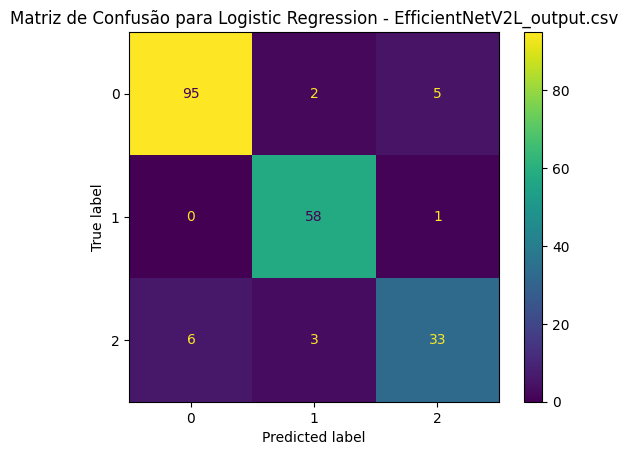

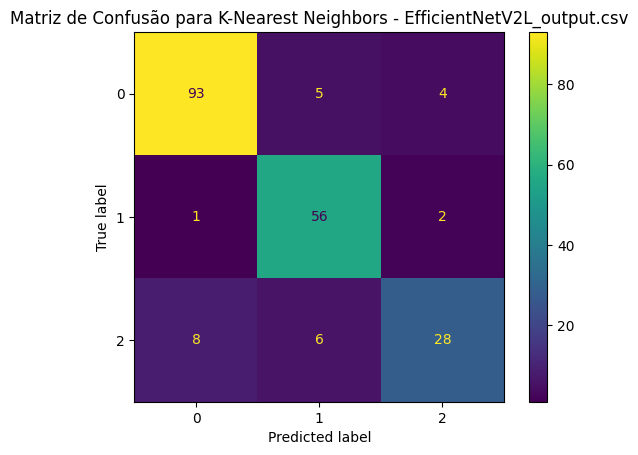

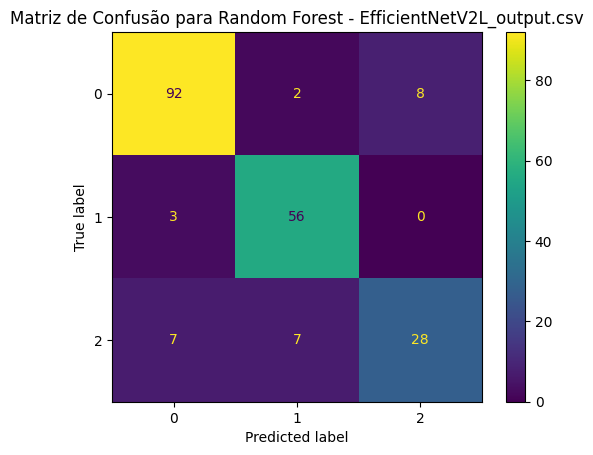

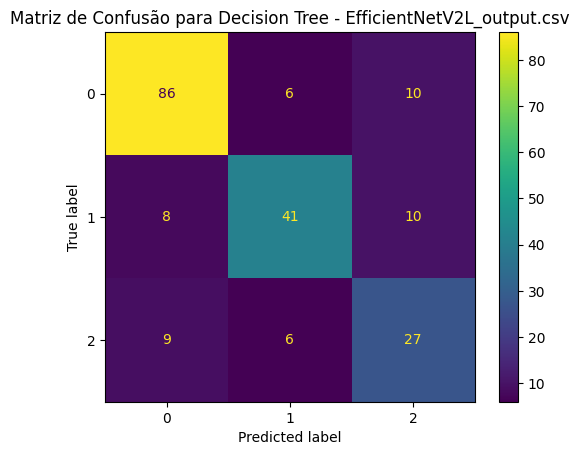

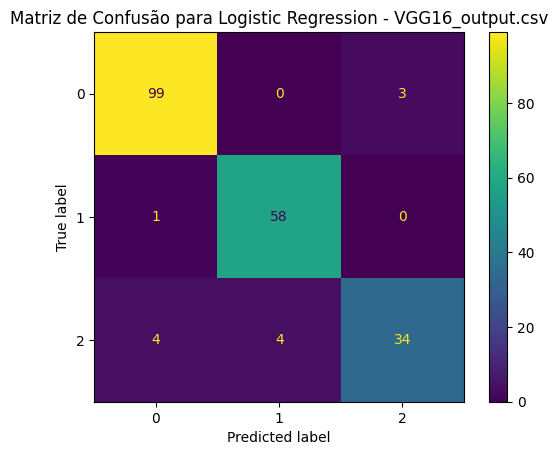

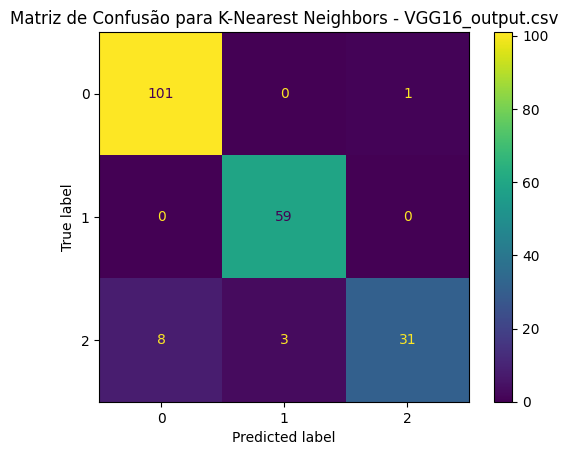

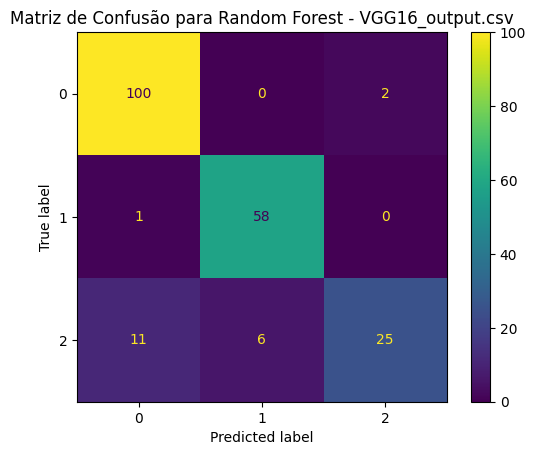

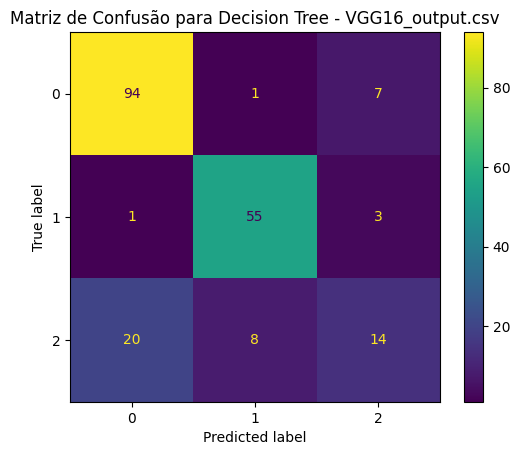

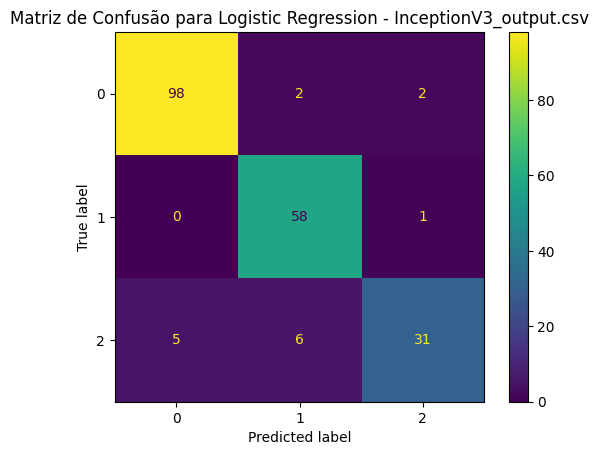

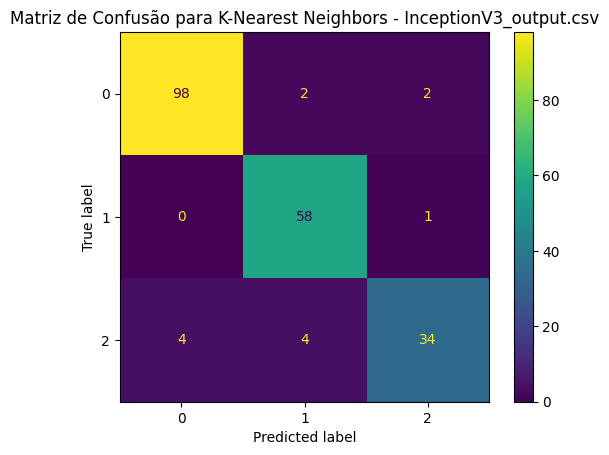

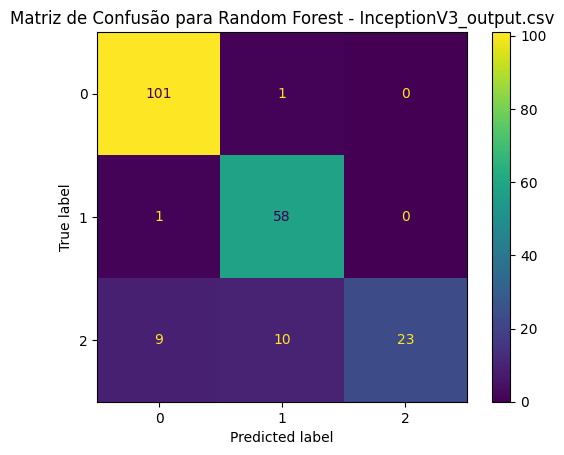

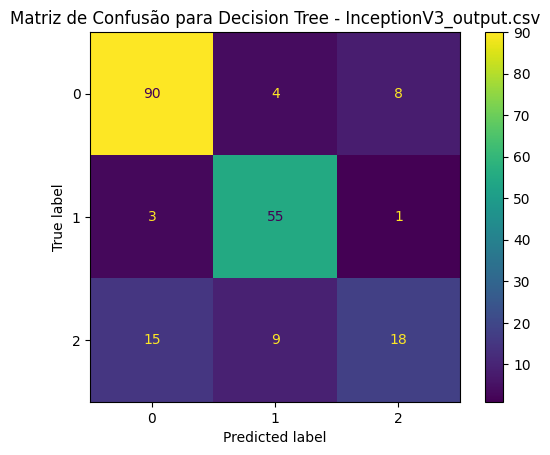

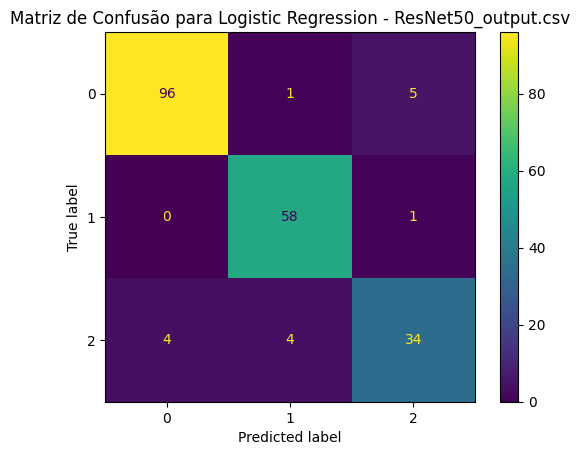

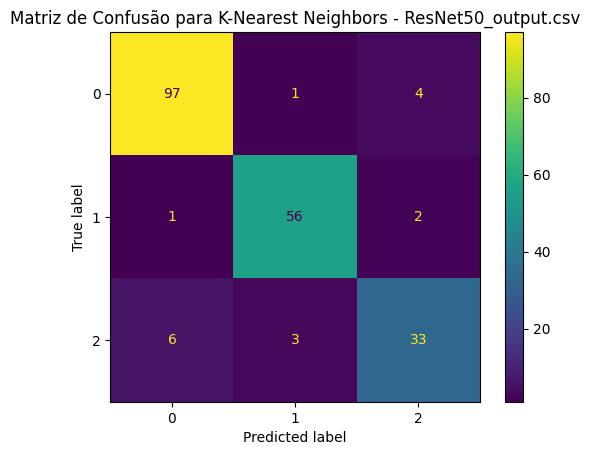

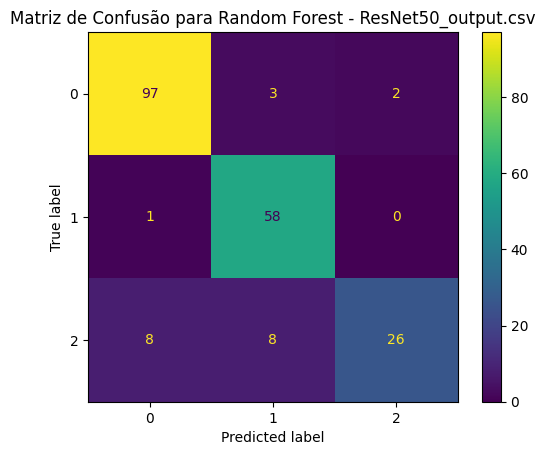

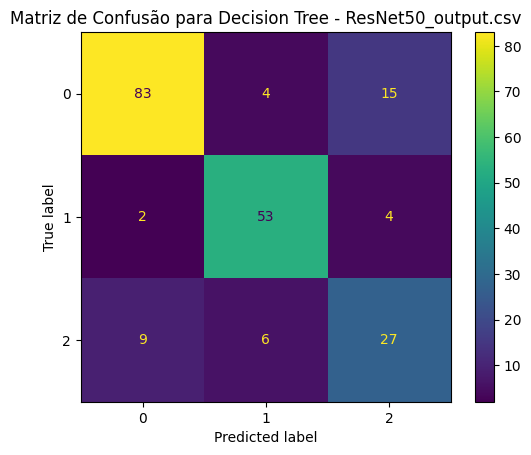

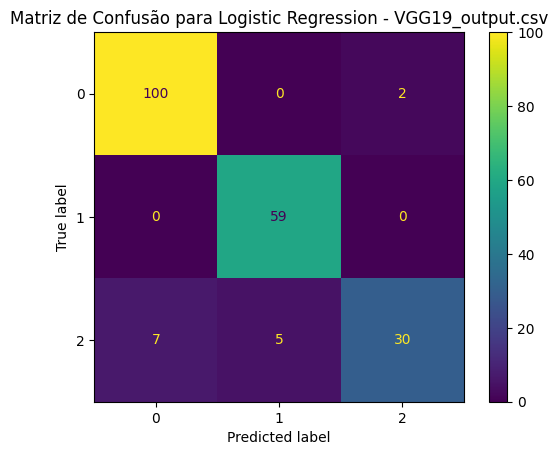

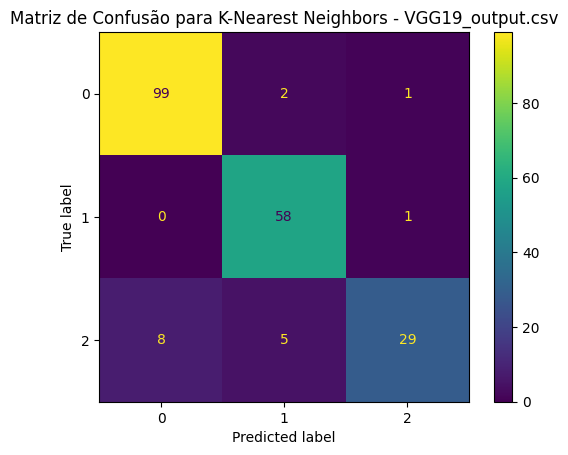

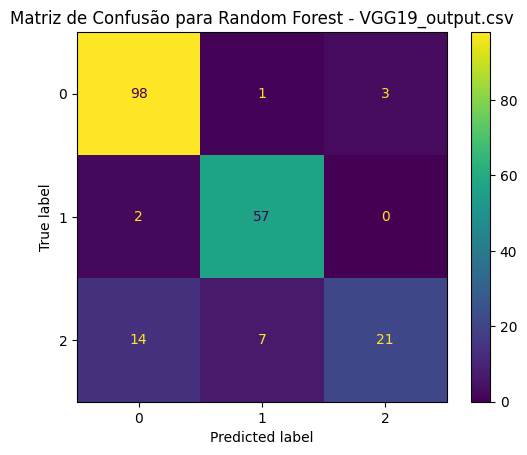

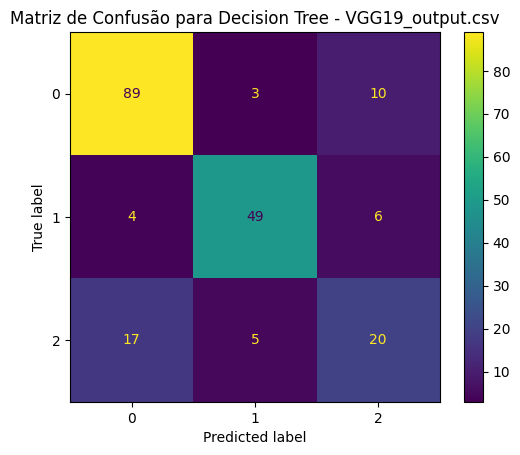

In [52]:
main(train_folder, test_folder)